# Binary QSAR in Python - LabMol

Developed by: 
#### José Teófilo Moreira Filho

#  <font color='white'> Model building with featmorgan fingerprint and RF, SVM and LightGBM </font>

In [1]:
import datetime
now = datetime.datetime.now()
print("date ofcreation:\n", now)

date ofcreation:
 2021-04-15 15:29:35.526149


In [2]:
# Importing packages 
from rdkit import Chem, DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import PandasTools

import numpy as np
from numpy import sqrt
from numpy import argmax

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import DataFrame

import os

import xgboost as xgb
import lightgbm as lgb

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, matthews_corrcoef, roc_curve, precision_recall_curve, roc_auc_score, make_scorer
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import auc as mauc
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.metrics import geometric_mean_score
from imblearn.under_sampling import TomekLinks

import multiprocessing

from skopt import BayesSearchCV

from mordred import Calculator, descriptors

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Check initial number of compounds

In [3]:
# Reading molecules and activity (0 and 1) from SDF
fname = "../data/1224857_bruno_imbalanced_prep.sdf"

In [4]:
df0 = PandasTools.LoadSDF(fname, smilesName='SMILES', includeFingerprints=False)

In [5]:
df0.columns

Index(['Outcome', 'pIC50', 'ID', 'SMILES', 'is_active', 'ROMol'], dtype='object')

In [6]:
df0["is_active"] = np.where(df0["Outcome"] == "Active", 1,0)

,Outcome,pIC50,ID,SMILES,is_active,ROMol
0,Inactive,4.861056598092725,,O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12,0,
1,Inactive,4.811057461628963,,N#C/C(=C\c1ccc(O)c(O)c1)C(=O)Nc1ccccc1,0,
2,Inactive,4.811057461628963,,Cc1csc(NC(=O)c2sc3nc4c(c(C(F)(F)F)c3c2N)CCC4)n1,0,
3,Inactive,4.650000220873454,,CC(C)(C)COc1ccc(-n2cc(C(=O)O)cn2)cc1C#N,0,
4,Inactive,4.7610561120364965,,CC(=O)Nc1ccc(C(C)C(=O)Nc2ncc(C(C)C)s2)cc1,0,

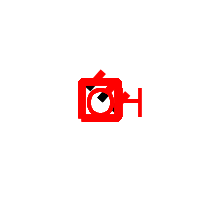
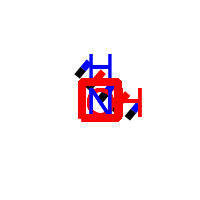
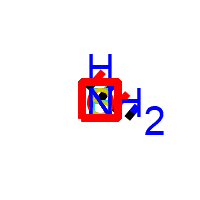
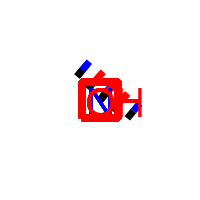
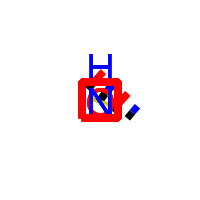

In [7]:
df0.head()

Class 0: 3478
Class 1: 43
Proportion: 80.88 : 1


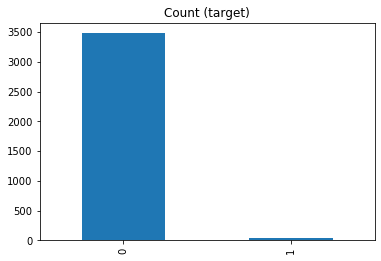

In [8]:
target_count = df0.is_active.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

In [9]:
#Save the table as SD file
#PandasTools.WriteSDF(df0, '../data/w2_isactive_5445.sdf', properties=df0.columns)

## Fingerprint and descriptors calculation

In [10]:
# Reading molecules and activity (0 and 1) from SDF
fname = "../data/1224857_bruno_imbalanced_prep.sdf"

mols = []
y = []
for mol in Chem.SDMolSupplier(fname):
    if mol is not None:
        mols.append(mol)
        y.append(mol.GetIntProp("is_active")) # target column

In [52]:
y = pd.DataFrame(y)

In [53]:
y = y.iloc[:,-1:].values.ravel()

In [11]:
# Calculate descriptors (fingerprints) and convert them into numpy array

# generate binary Morgan fingerprint with radius 2
fp = [AllChem.GetMorganFingerprintAsBitVect(m, 2, 2048, useFeatures=False) for m in mols]

def rdkit_numpy_convert(fp):
    output = []
    for f in fp:
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f, arr)
        output.append(arr)
    return np.asarray(output)
# Convert fingerprint to numpy array
x_fp = rdkit_numpy_convert(fp)

In [12]:
# Convert fingerprint to Pandas DataFram,e
x_fp = pd.DataFrame(x_fp)

In [13]:
# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

In [14]:
# Check the number of descriptors
len(calc.descriptors)

1613

In [15]:
# mordred descriptor calculation
df = calc.pandas(mols)

  5%|████▏                                                                          | 186/3521 [00:26<19:31,  2.85it/s]

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  7%|█████▎                                                                         | 236/3521 [00:32<17:09,  3.19it/s]

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  9%|███████▎                                                                       | 327/3521 [00:52<30:13,  1.76it/s]

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 76%|███████████████████████████████████████████████████████████▏                  | 2672/3521 [04:39<08:22,  1.69it/s]

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3402/3521 [05:51<00:31,  3.72it/s]

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████████████████████████████████████████████████████████████████████████| 3521/3521 [06:00<00:00,  9.77it/s]


In [16]:
# Print fisrt five rows
df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,15.015651,11.837076,0,0,24.700232,2.447452,4.894904,24.700232,1.300012,3.890021,...,9.964724,52.733581,254.057909,8.760618,694,31,102.0,121.0,6.027778,4.111111
1,15.803638,13.337477,0,0,26.690317,2.315762,4.631524,26.690317,1.270967,3.945888,...,9.683776,54.219832,280.084792,8.487418,1016,29,102.0,115.0,7.416667,4.805556
2,20.966332,18.025691,0,0,32.677538,2.583515,5.049966,32.677538,1.256828,4.219293,...,10.414183,78.775936,398.048288,10.206366,1581,43,148.0,180.0,9.423611,5.361111
3,16.837671,14.375348,1,0,26.786914,2.400017,4.750517,26.786914,1.217587,4.002539,...,9.871326,69.455761,299.126991,7.669923,1148,30,112.0,127.0,8.979167,4.791667
4,17.505581,14.665786,0,0,28.161820,2.348170,4.664850,28.161820,1.224427,4.039410,...,9.790823,70.332875,331.135448,7.525806,1385,31,114.0,129.0,9.138889,5.083333


In [17]:
# Check the number of compounds and descriptors
df.shape

(3521, 1613)

In [18]:
# Check the columns
df.columns

Index(['ABC', 'ABCGG', 'nAcid', 'nBase', 'SpAbs_A', 'SpMax_A', 'SpDiam_A',
       'SpAD_A', 'SpMAD_A', 'LogEE_A',
       ...
       'SRW10', 'TSRW10', 'MW', 'AMW', 'WPath', 'WPol', 'Zagreb1', 'Zagreb2',
       'mZagreb1', 'mZagreb2'],
      dtype='object', length=1613)

### Scale data

In [19]:
# scale data between 0 and 1
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df2 = pd.DataFrame(x_scaled)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\preprocessing\_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\preprocessing\_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [20]:
# Check the number of compounds and descriptors
df2.shape

(3521, 1613)

In [21]:
# Print fisrt five rows of the scaled DataFrame of descriptors
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612
0,0.268410,0.288423,0.000,0.0,0.254019,0.746562,0.774874,0.254019,0.824298,0.656438,...,0.835904,0.378647,0.145736,0.159273,0.024318,0.218310,0.264550,0.254237,0.156250,0.199643
1,0.282496,0.324981,0.000,0.0,0.276289,0.678639,0.704375,0.276289,0.776417,0.671211,...,0.809416,0.391086,0.162896,0.148834,0.035618,0.204225,0.264550,0.241525,0.206653,0.244207
2,0.374781,0.439215,0.000,0.0,0.343287,0.816740,0.816379,0.343287,0.753107,0.743509,...,0.878280,0.596612,0.240673,0.214514,0.055444,0.302817,0.386243,0.379237,0.279486,0.279857
3,0.300980,0.350270,0.125,0.0,0.277370,0.722096,0.736226,0.277370,0.688416,0.686191,...,0.827099,0.518606,0.175451,0.117598,0.040250,0.211268,0.291005,0.266949,0.263357,0.243316
4,0.312919,0.357347,0.000,0.0,0.292755,0.695355,0.713296,0.292755,0.699692,0.695941,...,0.819509,0.525947,0.196555,0.112091,0.048567,0.218310,0.296296,0.271186,0.269153,0.262032


In [22]:
# Print fisrt five rows of the first DataFrame of descriptors
df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,15.015651,11.837076,0,0,24.700232,2.447452,4.894904,24.700232,1.300012,3.890021,...,9.964724,52.733581,254.057909,8.760618,694,31,102.0,121.0,6.027778,4.111111
1,15.803638,13.337477,0,0,26.690317,2.315762,4.631524,26.690317,1.270967,3.945888,...,9.683776,54.219832,280.084792,8.487418,1016,29,102.0,115.0,7.416667,4.805556
2,20.966332,18.025691,0,0,32.677538,2.583515,5.049966,32.677538,1.256828,4.219293,...,10.414183,78.775936,398.048288,10.206366,1581,43,148.0,180.0,9.423611,5.361111
3,16.837671,14.375348,1,0,26.786914,2.400017,4.750517,26.786914,1.217587,4.002539,...,9.871326,69.455761,299.126991,7.669923,1148,30,112.0,127.0,8.979167,4.791667
4,17.505581,14.665786,0,0,28.161820,2.348170,4.664850,28.161820,1.224427,4.039410,...,9.790823,70.332875,331.135448,7.525806,1385,31,114.0,129.0,9.138889,5.083333


In [23]:
# Recuperate the name of columns lost during scaling
df2.columns=df.columns.values

In [24]:
# Print fisrt five rows 
df2.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.268410,0.288423,0.000,0.0,0.254019,0.746562,0.774874,0.254019,0.824298,0.656438,...,0.835904,0.378647,0.145736,0.159273,0.024318,0.218310,0.264550,0.254237,0.156250,0.199643
1,0.282496,0.324981,0.000,0.0,0.276289,0.678639,0.704375,0.276289,0.776417,0.671211,...,0.809416,0.391086,0.162896,0.148834,0.035618,0.204225,0.264550,0.241525,0.206653,0.244207
2,0.374781,0.439215,0.000,0.0,0.343287,0.816740,0.816379,0.343287,0.753107,0.743509,...,0.878280,0.596612,0.240673,0.214514,0.055444,0.302817,0.386243,0.379237,0.279486,0.279857
3,0.300980,0.350270,0.125,0.0,0.277370,0.722096,0.736226,0.277370,0.688416,0.686191,...,0.827099,0.518606,0.175451,0.117598,0.040250,0.211268,0.291005,0.266949,0.263357,0.243316
4,0.312919,0.357347,0.000,0.0,0.292755,0.695355,0.713296,0.292755,0.699692,0.695941,...,0.819509,0.525947,0.196555,0.112091,0.048567,0.218310,0.296296,0.271186,0.269153,0.262032


### Remove columns with NaN

In [25]:
# Check the existence of NaN values
df2.isnull().values.any()

True

In [26]:
# Drop the columns with NaN values
df3 = df2.dropna(axis = 1, how ='any')

In [27]:
# Check the number of compounds and descriptors
df3.shape

(3521, 1139)

In [28]:
# Check the existence of NaN values
df3.isnull().values.any()

False

In [29]:
# Print fisrt five rows 
df3.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.268410,0.288423,0.000,0.0,0.254019,0.746562,0.774874,0.254019,0.824298,0.656438,...,0.835904,0.378647,0.145736,0.159273,0.024318,0.218310,0.264550,0.254237,0.156250,0.199643
1,0.282496,0.324981,0.000,0.0,0.276289,0.678639,0.704375,0.276289,0.776417,0.671211,...,0.809416,0.391086,0.162896,0.148834,0.035618,0.204225,0.264550,0.241525,0.206653,0.244207
2,0.374781,0.439215,0.000,0.0,0.343287,0.816740,0.816379,0.343287,0.753107,0.743509,...,0.878280,0.596612,0.240673,0.214514,0.055444,0.302817,0.386243,0.379237,0.279486,0.279857
3,0.300980,0.350270,0.125,0.0,0.277370,0.722096,0.736226,0.277370,0.688416,0.686191,...,0.827099,0.518606,0.175451,0.117598,0.040250,0.211268,0.291005,0.266949,0.263357,0.243316
4,0.312919,0.357347,0.000,0.0,0.292755,0.695355,0.713296,0.292755,0.699692,0.695941,...,0.819509,0.525947,0.196555,0.112091,0.048567,0.218310,0.296296,0.271186,0.269153,0.262032


### Remove High correlated features

In [30]:
from sklearn.feature_selection import VarianceThreshold

In [31]:
# Constant descriptors
constant_filter = VarianceThreshold(threshold=0.01)  
constant_filter.fit(df3) 

VarianceThreshold(threshold=0.01)

In [32]:
# Number of not constant descriptors
len(df3.columns[constant_filter.get_support()])

534

In [33]:
# Number of constant descriptors
constant_columns = [column for column in df3.columns
                    if column not in df3.columns[constant_filter.get_support()]]

print(len(constant_columns))

605


In [34]:
# Remove constant columns
df4 = df3.drop(labels=constant_columns, axis=1)

In [35]:
# Print fisrt five rows 
df4.head()

,ABC,ABCGG,SpAbs_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE3_A,nAromAtom,nAromBond,...,SRW03,SRW05,SRW07,SRW09,TSRW10,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0.268410,0.288423,0.254019,0.254019,0.824298,0.656438,0.463080,0.651971,0.484848,0.500000,...,0.0,0.000000,0.000000,0.000000,0.378647,0.218310,0.264550,0.254237,0.156250,0.199643
1,0.282496,0.324981,0.276289,0.276289,0.776417,0.671211,0.499802,0.681777,0.363636,0.352941,...,0.0,0.000000,0.000000,0.000000,0.391086,0.204225,0.264550,0.241525,0.206653,0.244207
2,0.374781,0.439215,0.343287,0.343287,0.753107,0.743509,0.510766,0.727197,0.424242,0.441176,...,0.0,0.716042,0.832025,0.847619,0.596612,0.302817,0.386243,0.379237,0.279486,0.279857
3,0.300980,0.350270,0.277370,0.277370,0.688416,0.686191,0.491582,0.688885,0.333333,0.323529,...,0.0,0.500000,0.661731,0.712892,0.518606,0.211268,0.291005,0.266949,0.263357,0.243316
4,0.312919,0.357347,0.292755,0.292755,0.699692,0.695941,0.539280,0.709989,0.333333,0.323529,...,0.0,0.500000,0.661731,0.710231,0.525947,0.218310,0.296296,0.271186,0.269153,0.262032


In [36]:
# Check the number of compounds and descriptors
df4.shape

(3521, 534)

In [37]:
# Calculate correlation
correlated_features = set()
correlation_matrix = df4.corr()

In [38]:
threshold = 0.90

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [39]:
# Remove correlated columns
df_clean = df4.drop(labels=correlated_features, axis=1)

In [40]:
# Print fisrt five rows 
df_clean.head()

,ABC,SpMAD_A,VE1_A,nAromAtom,nN,AATS2d,ATSC1d,ATSC3d,ATSC4d,ATSC0s,...,JGI3,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW03,SRW05
0,0.268410,0.824298,0.463080,0.484848,0.000000,0.621142,0.162510,0.607121,0.683565,0.144124,...,0.309140,0.349020,0.350671,0.303922,0.511054,0.299415,0.907865,0.833333,0.0,0.000000
1,0.282496,0.776417,0.499802,0.363636,0.142857,0.522876,0.139366,0.623114,0.704072,0.177159,...,0.287356,0.215686,0.334403,0.315686,0.170068,0.348751,0.363483,1.000000,0.0,0.000000
2,0.374781,0.753107,0.510766,0.424242,0.285714,0.618975,0.215279,0.647392,0.472080,0.326832,...,0.511413,0.375076,0.447427,0.236833,0.440519,0.275154,0.521984,1.000000,0.0,0.716042
3,0.300980,0.688416,0.491582,0.333333,0.214286,0.486457,0.205021,0.780511,0.896018,0.162105,...,0.236111,0.445008,0.309241,0.414903,0.559933,0.331973,0.536360,1.000000,0.0,0.500000
4,0.312919,0.699692,0.539280,0.333333,0.214286,0.425685,0.229865,0.615092,0.655109,0.147801,...,0.370370,0.321631,0.408473,0.285752,0.357344,0.240926,0.394288,1.000000,0.0,0.500000


In [41]:
columns = pd.DataFrame(df_clean.columns.values)

In [42]:
columns = columns.set_index(0).transpose()

In [43]:
columns.to_csv('../results/descriptor_list_hybrid_mordred_morgan_r2_2048_imbalanced.csv', index=False)

### Join fingerprint to Mordred descriptors

In [44]:
# Join fingerprint to Mordred descriptors
x = df_clean.join(x_fp)

In [45]:
# Print fisrt five rows
x.head()

,ABC,SpMAD_A,VE1_A,nAromAtom,nN,AATS2d,ATSC1d,ATSC3d,ATSC4d,ATSC0s,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.268410,0.824298,0.463080,0.484848,0.000000,0.621142,0.162510,0.607121,0.683565,0.144124,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.282496,0.776417,0.499802,0.363636,0.142857,0.522876,0.139366,0.623114,0.704072,0.177159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.374781,0.753107,0.510766,0.424242,0.285714,0.618975,0.215279,0.647392,0.472080,0.326832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.300980,0.688416,0.491582,0.333333,0.214286,0.486457,0.205021,0.780511,0.896018,0.162105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.312919,0.699692,0.539280,0.333333,0.214286,0.425685,0.229865,0.615092,0.655109,0.147801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Check the number of compounds and descriptors
x.shape

(3521, 2217)

In [47]:
x = np.array(x)

In [54]:
print(len(x))
type(x)

3521


numpy.ndarray

In [55]:
print(len(y))
type(y)

3521


numpy.ndarray

## Data splitting

In [56]:
#Create folds for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## RF Model building - Bayesian hyperparameter search  

In [57]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {'max_features': ['auto', 'sqrt'],
    'n_estimators': [100, 1000],
    "max_depth": [2, 100],
    'min_samples_leaf': [1,20], 
    'min_samples_split': [2, 20]
    },
    n_iter=50, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    verbose=0,
    refit= True, # Refit the best estimator with the entire dataset.
    random_state=42, 
    n_jobs = -1
)

opt_rf.fit(x, y)

print("Best parameters: %s" % opt_rf.best_params_)

Best parameters: OrderedDict([('max_depth', 42), ('max_features', 'sqrt'), ('min_samples_leaf', 19), ('min_samples_split', 8), ('n_estimators', 703)])


## 5-fold cross-validation

In [58]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    rf_clf = RandomForestClassifier(**opt_rf.best_params_) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    rf_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = rf_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#   indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [59]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [60]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [61]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.5
Balanced accuracy (fold 2) =  0.5
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.5
Balanced accuracy (fold 5) =  0.5


## Check mean performance of folds

In [62]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [63]:
# Uncalibrated model predictions
pred_rf = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - featmorgan-RF

In [64]:
def calc_statistics(y,pred):
    # save confusion matrix and slice into four pieces
    confusion = confusion_matrix(y, pred)
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    # Plot confusion
    #plt.figure(figsize=(5,5))
    #sns.heatmap(confusion, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    #plt.ylabel('Actual label');
    #plt.xlabel('Predicted label');
    #title = "Confusion matrix"
    #plt.title(title, size = 15);
    
    # calc statistics
    classification_error = 1 - accuracy_score(y, pred) #Classification error or misclassification rate
    accuracy = accuracy_score(y, pred) #accuracy
    mcc = matthews_corrcoef(y, pred) #mcc
    kappa = cohen_kappa_score(y, pred) #kappa
    sensitivity = recall_score(y, pred) #Sensitivity
    specificity = TN / (TN + FP) #Specificity
    false_positive_rate = FP / float(TN + FP) #False positive rate (alfa)
    false_negative_rate = FN / float(TP+FN) #False negative rate (beta)
    precision = TP / float(TP + FP) #Precision
    positive_pred_value = TP / float(TP + FP) #PPV
    negative_pred_value = TN / float(TN + FN) #NPV
    auc = roc_auc_score(y, pred) #AUC
    bacc = balanced_accuracy_score(y, pred) # balanced accuracy
    f1 = f1_score(y, pred) # F1-score

    print("Accuracy = ", accuracy)
    print("MCC = ", mcc)
    print("Kappa = ", kappa)
    print("Sensitivity = ", sensitivity)
    print("Specificity = ", specificity)
    print("Precision = ", precision)
    print("PPV = ", positive_pred_value)
    print("NPV = ", negative_pred_value)
    print("False positive rate = ", false_positive_rate)
    print("False negative rate = ", false_negative_rate)
    print("AUC = ",roc_auc_score(y, pred))
    print("Classification error = ", classification_error)
    print("Balanced accuracy = ", bacc)
    print("F1-score = ", f1)
    
    #converting calculated metrics into a pandas dataframe to compare all models at the final
    statistics = pd.DataFrame({'Bal-acc': bacc, "Sensitivity": sensitivity, "Specificity": specificity,"PPV": positive_pred_value, 
           "NPV": negative_pred_value, 'Kappa': kappa, 'AUC': auc, 'MCC': mcc, 'Accuracy': accuracy, 
           "Classification error": classification_error,"False positive rate": false_positive_rate, 
           "False negative rate": false_negative_rate, "Precision": precision, 'F1-score': f1,}, index=[0])
    return(statistics)

In [65]:
statistics = calc_statistics(y_experimental, pred_rf)

Accuracy =  0.9877875603521726
MCC =  0.0
Kappa =  0.0
Sensitivity =  0.0
Specificity =  1.0
Precision =  nan
PPV =  nan
NPV =  0.9877875603521726
False positive rate =  0.0
False negative rate =  1.0
AUC =  0.5
Classification error =  0.012212439647827367
Balanced accuracy =  0.5
F1-score =  0.0


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


In [66]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "hybrid_mordred_morgan_r2_2048_rf"

result_type = "uncalibrated"

metrics_rf_uncalibrated = statistics
metrics_rf_uncalibrated['model'] = model_type
metrics_rf_uncalibrated['result_type'] = result_type
metrics_rf_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.5,0.0,1.0,NaN,0.987788,0.0,0.5,0.0,0.987788,0.012212,0.0,1.0,NaN,0.0,hybrid_mordred_morgan_r2_2048_rf,uncalibrated


### Check model calibatrion

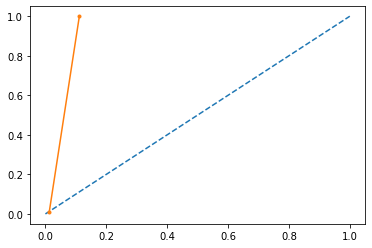

In [67]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_hybrid_mordred_morgan_r2_2048_rf_dataset-1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.022507, G-Mean=0.802


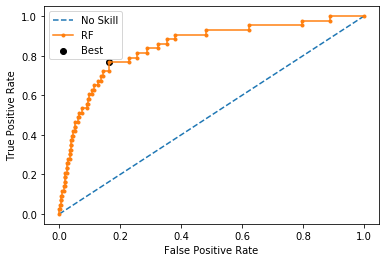

In [68]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RF')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_hybrid_mordred_morgan_r2_2048_rf_dataset-1224857_bruno_imbalanced.png', dpi=300)

In [69]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.02250664145382318


### Optimal Threshold for Precision-Recall Curve

In [70]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.047332, F-Score=0.167


In [71]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.04733227472228565


### Statistics model calibrated - Choose the best calibration method before

In [72]:
# Select the best threshold to distinguishthe classes
pred_rf = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_rf = (probs_classes[:, 1] > threshold_prc).astype(int)

In [73]:
statistics = calc_statistics(y_experimental, pred_rf)

Accuracy =  0.8364101107639875
MCC =  0.1702744076557264
Kappa =  0.07901646520727046
Sensitivity =  0.7441860465116279
Specificity =  0.8375503162737206
Precision =  0.05360134003350084
PPV =  0.05360134003350084
NPV =  0.9962380300957593
False positive rate =  0.16244968372627946
False negative rate =  0.2558139534883721
AUC =  0.7908681813926742
Classification error =  0.16358988923601248
Balanced accuracy =  0.7908681813926742
F1-score =  0.1


In [74]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "featmorgan_r2_2048_rf"

result_type = "calibrated"

metrics_rf_calibrated = statistics
metrics_rf_calibrated['model'] = model_type
metrics_rf_calibrated['result_type'] = result_type
metrics_rf_calibrated['calibration_threshold'] = threshold_roc
metrics_rf_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.790868,0.744186,0.83755,0.053601,0.996238,0.079016,0.790868,0.170274,0.83641,0.16359,0.16245,0.255814,0.053601,0.1,featmorgan_r2_2048_rf,calibrated,0.022507


In [75]:
# Saving the dataframe as excel file
#metrics_rf_calibrated.to_excel("../results/model_binary_metrics_rf_featmorgan_r2_gmean_mpro_newdata_thres028.xlsx", sheet_name= "Sheet1")

### Save model

In [77]:
#Save model - pkl file
joblib.dump(opt_rf, "../models/model_binary_rf_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_rf_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl']

## SVM Model building - Bayesian hyperparameter search  

In [78]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_svm = BayesSearchCV(
    SVC(probability=True),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'kernel': ['rbf'],  # categorical parameter | ['linear', 'poly', 'rbf'] to test all kernels
    },
    n_iter=50, # Number of parameter settings that are sampled
    cv=cv,
    scoring = scorer,
    refit = True, # Refit the best estimator with the entire dataset.
    random_state=42,
    n_jobs = -1
)

opt_svm.fit(x, y)

print("Best parameters: %s" % opt_svm.best_params_)

C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best parameters: OrderedDict([('C', 1000000.0), ('gamma', 0.021080916647988484), ('kernel', 'rbf')])


## 5-fold cross-validation

In [79]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    svm_clf = SVC(**opt_svm.best_params_, probability=True) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    svm_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = svm_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#  indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [80]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [81]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [82]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.5526819923371648
Balanced accuracy (fold 2) =  0.5625
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.49928057553956834
Balanced accuracy (fold 5) =  0.49928057553956834


## Check mean performance of folds

In [83]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [84]:
# Uncalibrated model predictions
pred_svm = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - featmorgan-SVM

In [85]:
# Uncalibrated model predictions
pred_svm = (probs_classes[:, 1] > 0.5).astype(int)
len(y_experimental)

3521

In [86]:
statistics = calc_statistics(y_experimental, pred_svm)

Accuracy =  0.9866515194547004
MCC =  0.10331468554515809
Kappa =  0.07488693727184803
Sensitivity =  0.046511627906976744
Specificity =  0.9982748706152962
Precision =  0.25
PPV =  0.25
NPV =  0.9883290634785084
False positive rate =  0.0017251293847038527
False negative rate =  0.9534883720930233
AUC =  0.5223932492611365
Classification error =  0.01334848054529958
Balanced accuracy =  0.5223932492611365
F1-score =  0.07843137254901962


In [87]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "hybrid_mordred_morgan_r2_2048_svm"

result_type = "uncalibrated"

metrics_svm_uncalibrated = statistics
metrics_svm_uncalibrated['model'] = model_type
metrics_svm_uncalibrated['result_type'] = result_type
metrics_svm_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.522393,0.046512,0.998275,0.25,0.988329,0.074887,0.522393,0.103315,0.986652,0.013348,0.001725,0.953488,0.25,0.078431,hybrid_mordred_morgan_r2_2048_svm,uncalibrated


### Check model calibatrion

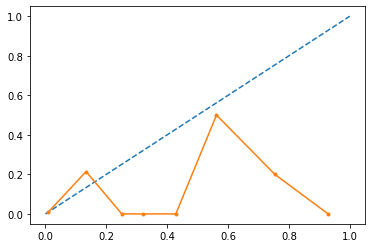

In [88]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_hybrid_mordred_morgan_r2_2048_svm_dataset-1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.013623, G-Mean=0.774


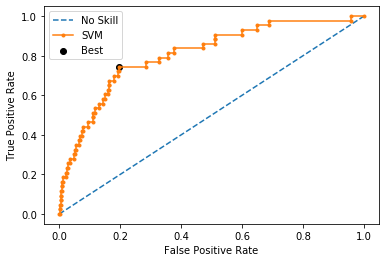

In [89]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='SVM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_hybrid_mordred_morgan_r2_2048_svm_dataset-1224857_bruno_imbalanced.png', dpi=300)

In [90]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.013622954680965332


### Optimal Threshold for Precision-Recall Curve

In [91]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.928902, F-Score=nan


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [92]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.9289018444787205


### Statistics model calibrated - Choose the best calibration method before

In [93]:
# Select the best threshold to distinguishthe classes
pred_svm = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_svm = (probs_classes[:, 1] > threshold_prc).astype(int)

In [94]:
statistics = calc_statistics(y_experimental, pred_svm)

Accuracy =  0.8040329451860267
MCC =  0.14406093652927815
Kappa =  0.060819122180222895
Sensitivity =  0.7209302325581395
Specificity =  0.8050603795284647
Precision =  0.04372355430183357
PPV =  0.04372355430183357
NPV =  0.9957325746799431
False positive rate =  0.19493962047153537
False negative rate =  0.27906976744186046
AUC =  0.7629953060433021
Classification error =  0.19596705481397325
Balanced accuracy =  0.7629953060433021
F1-score =  0.0824468085106383


In [95]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "hybrid_mordred_morgan_r2_2048_svm"

result_type = "calibrated"

metrics_svm_calibrated = statistics
metrics_svm_calibrated['model'] = model_type
metrics_svm_calibrated['result_type'] = result_type
metrics_svm_calibrated['calibration_threshold'] = threshold_roc
metrics_svm_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.762995,0.72093,0.80506,0.043724,0.995733,0.060819,0.762995,0.144061,0.804033,0.195967,0.19494,0.27907,0.043724,0.082447,hybrid_mordred_morgan_r2_2048_svm,calibrated,0.013623


In [96]:
# Saving the dataframe as excel file
#metrics_svm.to_excel("../results/model_binary_metrics_svm_featmorgan_r2_gmean_mpro_newdata_thres039.xlsx", sheet_name= "Sheet1")

### Save model

In [97]:
#Save model - pkl file
joblib.dump(opt_svm, "../models/model_binary_svm_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_svm_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl']

## LightGBM Model building - Bayesian hyperparameter search

In [98]:
scorer = make_scorer(geometric_mean_score)

# log-uniform: understand as search over p = exp(x) by varying x
opt_lgb = BayesSearchCV(lgb.LGBMClassifier(),
                        {'learning_rate': (0.01, 1.0, 'log-uniform'), 
                         'num_leaves': (7, 4095),
                         'n_estimators': (100, 800), 
                         'max_depth': (2, 63),
                         'subsample': (0.4, 1), 
                         'scale_pos_weight': (1, 1000)}, 
                        n_iter = 50, # Number of parameter settings that are sampled
                        cv = cv, 
                        scoring = scorer,
                        refit = True, # Refit the best estimator with the entire dataset.
                        verbose = 0,
                        random_state = 42, 
                        n_jobs = 1)

opt_lgb.fit(x, y)

print("Best parameters: %s" % opt_lgb.best_params_)

Best parameters: OrderedDict([('learning_rate', 0.01), ('max_depth', 2), ('n_estimators', 321), ('num_leaves', 4095), ('scale_pos_weight', 795), ('subsample', 0.4)])


## 5-fold cross-validation

In [99]:
probs_classes = []
#indexes = []
y_test_all = []

for train_index, test_index in cv.split(x, y):
    lgb_clf = lgb.LGBMClassifier(**opt_lgb.best_params_,) # model with best parameters
    X_train_folds = x[train_index] # descritors train split
    y_train_folds = np.array(y)[train_index.astype(int)] # label train split
    X_test_fold = x[test_index] # descritors test split
    y_test_fold = np.array(y)[test_index.astype(int)] # label test split
    
    
    svm_clf.fit(X_train_folds, y_train_folds) # train fold
    y_pred = svm_clf.predict_proba(X_test_fold) # test fold
    probs_classes.append(y_pred) # all predictions for test folds
    y_test_all.append(y_test_fold) # all folds' labels 
#  indexes.append(test_index) # all tests indexes

## Check performance of each fold

In [100]:
# Get predictions of each fold
fold_1_pred = (probs_classes[0][:, 1] > 0.5).astype(int)
fold_2_pred = (probs_classes[1][:, 1] > 0.5).astype(int)
fold_3_pred = (probs_classes[2][:, 1] > 0.5).astype(int)
fold_4_pred = (probs_classes[3][:, 1] > 0.5).astype(int)
fold_5_pred = (probs_classes[4][:, 1] > 0.5).astype(int)

In [101]:
# Get experimental values of each fold
fold_1_exp = y_test_all[0]
fold_2_exp = y_test_all[1]
fold_3_exp = y_test_all[2]
fold_4_exp = y_test_all[3]
fold_5_exp = y_test_all[4]

In [102]:
bacc1 = metrics.balanced_accuracy_score(fold_1_exp, fold_1_pred) # balanced accuracy fold 1
bacc2 = metrics.balanced_accuracy_score(fold_2_exp, fold_2_pred) # balanced accuracy fold 2
bacc3 = metrics.balanced_accuracy_score(fold_3_exp, fold_3_pred) # balanced accuracy fold 3
bacc4 = metrics.balanced_accuracy_score(fold_4_exp, fold_4_pred) # balanced accuracy fold 4
bacc5 = metrics.balanced_accuracy_score(fold_5_exp, fold_5_pred) # balanced accuracy fold 5
print("Balanced accuracy (fold 1) = ", bacc1)
print("Balanced accuracy (fold 2) = ", bacc2)
print("Balanced accuracy (fold 3) = ", bacc3)
print("Balanced accuracy (fold 4) = ", bacc4)
print("Balanced accuracy (fold 5) = ", bacc5)

Balanced accuracy (fold 1) =  0.5526819923371648
Balanced accuracy (fold 2) =  0.5625
Balanced accuracy (fold 3) =  0.5
Balanced accuracy (fold 4) =  0.49928057553956834
Balanced accuracy (fold 5) =  0.49928057553956834


## Check mean performance of folds

In [103]:
probs_classes = np.concatenate(probs_classes)    
y_experimental = np.concatenate(y_test_all)

In [104]:
# Uncalibrated model predictions
pred_lgb = (probs_classes[:, 1] > 0.5).astype(int)

### Statistics - featmorgan-LGB

In [105]:
pred_lgb = (probs_classes[:, 1] > 0.5).astype(int)

In [106]:
statistics = calc_statistics(y_experimental, pred_lgb)

Accuracy =  0.9866515194547004
MCC =  0.10331468554515809
Kappa =  0.07488693727184803
Sensitivity =  0.046511627906976744
Specificity =  0.9982748706152962
Precision =  0.25
PPV =  0.25
NPV =  0.9883290634785084
False positive rate =  0.0017251293847038527
False negative rate =  0.9534883720930233
AUC =  0.5223932492611365
Classification error =  0.01334848054529958
Balanced accuracy =  0.5223932492611365
F1-score =  0.07843137254901962


In [107]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "hybrid_mordred_morgan_r2_2048_lgb"

result_type = "uncalibrated"

metrics_lgb_uncalibrated = statistics
metrics_lgb_uncalibrated['model'] = model_type
metrics_lgb_uncalibrated['result_type'] = result_type
metrics_lgb_uncalibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type
0,0.522393,0.046512,0.998275,0.25,0.988329,0.074887,0.522393,0.103315,0.986652,0.013348,0.001725,0.953488,0.25,0.078431,hybrid_mordred_morgan_r2_2048_lgb,uncalibrated


### Check model calibatrion

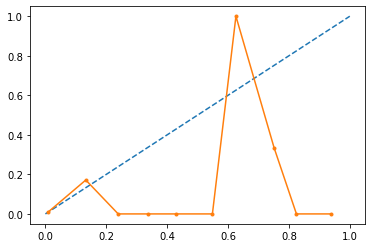

In [108]:
# keep probabilities for the positive outcome only
probs = probs_classes[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_experimental, probs, n_bins=10)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(mpv, fop, marker='.')
#plt.show()
plt.savefig('../results/calibration_model_hybrid_mordred_morgan_r2_2048_lgb_dataset-1224857_bruno_imbalanced.png', dpi=300)

### Use ROC-Curve and Gmean to select a threshold for calibration

Best Threshold=0.012714, G-Mean=0.769


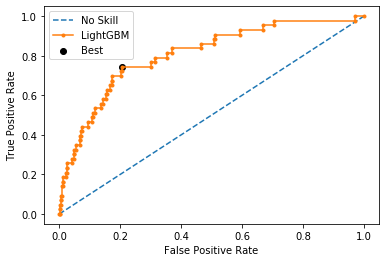

In [109]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_experimental, yhat)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LightGBM')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
#plt.show()
plt.savefig('../results/calibration_curve_hybrid_mordred_morgan_r2_2048_lgb_dataset-1224857_bruno_imbalanced.png', dpi=300)

In [110]:
# Record the threshold in a variable
threshold_roc = thresholds[ix]
print(threshold_roc)

0.01271393208259744


### Optimal Threshold for Precision-Recall Curve

In [111]:
# keep probabilities for the positive outcome only
yhat = probs_classes[:, 1]
# calculate precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_experimental, yhat)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.790298, F-Score=nan


C:\Users\tiofi\PyMOL\envs\rdkit2\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [112]:
# Record the threshold in a variable
threshold_prc = thresholds[ix]
print(threshold_prc)

0.7902983294172963


### Statistics model calibrated - Choose the best calibration method before

In [113]:
# Select the best threshold to distinguishthe classes
pred_lgb = (probs_classes[:, 1] > threshold_roc).astype(int)
# pred_lgb = (probs_classes[:, 1] > threshold_prc).astype(int)

In [114]:
statistics = calc_statistics(y_experimental, pred_lgb)

Accuracy =  0.7935245668844079
MCC =  0.13851676485031064
Kappa =  0.056798430900327324
Sensitivity =  0.7209302325581395
Specificity =  0.7944220816561242
Precision =  0.04155495978552279
PPV =  0.04155495978552279
NPV =  0.9956756756756757
False positive rate =  0.2055779183438758
False negative rate =  0.27906976744186046
AUC =  0.7576761571071319
Classification error =  0.20647543311559213
Balanced accuracy =  0.7576761571071318
F1-score =  0.07858048162230671


In [115]:
#converting calculated metrics into a pandas dataframe to save a xls
model_type = "hybrid_mordred_morgan_r2_2048_lgb"

result_type = "calibrated"

metrics_lgb_calibrated = statistics
metrics_lgb_calibrated['model'] = model_type
metrics_lgb_calibrated['result_type'] = result_type
metrics_lgb_calibrated['calibration_threshold'] = threshold_roc
metrics_lgb_calibrated

,Bal-acc,Sensitivity,Specificity,PPV,NPV,Kappa,AUC,MCC,Accuracy,Classification error,False positive rate,False negative rate,Precision,F1-score,model,result_type,calibration_threshold
0,0.757676,0.72093,0.794422,0.041555,0.995676,0.056798,0.757676,0.138517,0.793525,0.206475,0.205578,0.27907,0.041555,0.07858,hybrid_mordred_morgan_r2_2048_lgb,calibrated,0.012714


In [116]:
# Saving the dataframe as excel file
#metrics_lgb.to_excel("../results/model_binary_metrics_lgb_featmorgan_bee_mpro_newdata_gmean_NO_classweight_thres029.xlsx", sheet_name= "Sheet1")

### Save model

In [117]:
#Save model - pkl file
joblib.dump(opt_lgb, "../models/model_binary_lgb_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl", compress=3)

['../models/model_binary_lgb_hybrid_mordred_morgan_r2_2048_gmean_dataset-1224857_bruno_imbalanced.pkl']

## Compare all models

## Save an excell with all results

In [118]:
frames = [metrics_rf_uncalibrated, metrics_svm_uncalibrated, metrics_lgb_uncalibrated, 
          metrics_rf_calibrated, metrics_svm_calibrated, metrics_lgb_calibrated]

result = pd.concat(frames)
column_names = ["model", "Bal-acc", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "Kappa", "MCC", "AUC", "F1-score", 
                "Classification error", "False positive rate", "False negative rate", "result_type", "calibration_threshold"]
result = result.reindex(columns=column_names)
result = result.round(2)

In [119]:
result

,model,Bal-acc,Accuracy,Sensitivity,Specificity,PPV,NPV,Kappa,MCC,AUC,F1-score,Classification error,False positive rate,False negative rate,result_type,calibration_threshold
0,hybrid_mordred_morgan_r2_2048_rf,0.50,0.99,0.00,1.00,NaN,0.99,0.00,0.00,0.50,0.00,0.01,0.00,1.00,uncalibrated,NaN
0,hybrid_mordred_morgan_r2_2048_svm,0.52,0.99,0.05,1.00,0.25,0.99,0.07,0.10,0.52,0.08,0.01,0.00,0.95,uncalibrated,NaN
0,hybrid_mordred_morgan_r2_2048_lgb,0.52,0.99,0.05,1.00,0.25,0.99,0.07,0.10,0.52,0.08,0.01,0.00,0.95,uncalibrated,NaN
0,featmorgan_r2_2048_rf,0.79,0.84,0.74,0.84,0.05,1.00,0.08,0.17,0.79,0.10,0.16,0.16,0.26,calibrated,0.02
0,hybrid_mordred_morgan_r2_2048_svm,0.76,0.80,0.72,0.81,0.04,1.00,0.06,0.14,0.76,0.08,0.20,0.19,0.28,calibrated,0.01
0,hybrid_mordred_morgan_r2_2048_lgb,0.76,0.79,0.72,0.79,0.04,1.00,0.06,0.14,0.76,0.08,0.21,0.21,0.28,calibrated,0.01


In [120]:
# Saving the dataframe as excel file
result.to_excel("../results/metrics_binary_hybrid_mordred_morgan_r2_2048_lgb_allmodels_dataset-1224857_bruno_imbalanced.xlsx", sheet_name= "Sheet1")